In [251]:
import pandas as pd
import pymysql
import numpy as np
import os
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.pyplot as plt
from sklearn.decomposition import NMF
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from scipy import stats
from tensorly.decomposition import parafac
#
# Remove the limit on column width
pd.set_option('display.max_colwidth', None)

In [252]:
df = pd.read_csv('values.csv')
df_c = pd.read_csv('countries.csv')
df_i = pd.read_csv('indicators.csv')

In [253]:
#joining to insert the region in the values table
df_ = pd.merge(df,df_c, on='country_id',how='left' )

In [254]:
#It has some NANs as it has some countries that are not present in the countries table.
#Hence we delete those values
df_.isna().sum()

country_id        0
indicator_id      0
year              0
value             0
country_name    288
region          288
dtype: int64

In [255]:
df_countries_missing = set(df['country_id']) - set(df_c['country_id']) #not in df_C
df_countries_missing
df_countries_missing_fromc = set(df_c['country_id']) - set(df['country_id']) 
df_countries_missing_fromc
print(df_countries_missing , df_countries_missing_fromc) # find the difference in countries to see if to delete


{'AFE', 'AFW', 'ABW', 'AFG'} set()


In [256]:
df_.dropna(inplace=True)

In [257]:
df_regions_countries = df_.groupby('region')['country_id'].unique().reset_index()

In [258]:
df_regions_countries

,region,country_id
0,Africa,"[AGO, BDI, BEN, BFA, BWA, CAF, CIV, CMR, COD, COG, COM, CPV, ERI, ETH, GAB, GHA, GIN, GMB, GNB, GNQ, KEN, LBR, LSO, MDG, MLI, MOZ, MRT, MUS, MWI, NAM, NER, NGA, RWA, SDN, SEN, SLE, SOM, SSD, STP, SWZ, SYC, TCD, TGO, TZA, UGA, ZAF, ZMB, ZWE]"
1,East Asia and Pacific,"[BRN, CHN, GUM, HKG, IDN, JPN, KHM, KOR, LAO, MAC, MMR, MNG, MNP, MYS, PHL, PNG, PRK, SGP, THA, TLS, VNM]"
2,Europe and Central Asia,"[ALB, AND, ARM, AUT, AZE, BEL, BGR, BIH, BLR, CHE, CHI, CYP, CZE, DEU, DNK, ESP, EST, FIN, FRA, FRO, GBR, GEO, GIB, GRC, GRL, HRV, HUN, IMN, IRL, ISL, ITA, KAZ, KGZ, LIE, LTU, LUX, LVA, MCO, MDA, MKD, MLT, MNE, NLD, NOR, POL, PRT, ROU, RUS, SMR, SRB, SVK, SVN, SWE, TJK, TKM, TUR, UKR, UZB, XKX]"
3,Latin America and the Caribbean,"[ARG, ATG, BHS, BLZ, BMU, BOL, BRA, BRB, CHL, COL, CRI, CUB, CUW, CYM, DMA, DOM, ECU, GRD, GTM, GUY, HND, HTI, JAM, KNA, LCA, MAF, MEX, NIC, PAN, PER, PRY, SLV, SUR, SXM, TCA, TTO, URY, VCT, VEN, VGB, VIR]"
4,"Middle East, North Africa, Afghanistan & Pakistan","[ARE, BHR, DJI, DZA, EGY, IRN, IRQ, ISR, JOR, KWT, LBN, LBY, MAR, OMN, PAK, PSE, QAT, SAU, SYR, TUN, YEM]"
5,North America,"[CAN, PRI, USA]"
6,OCEANIA,"[ASM, AUS, FJI, FSM, KIR, MHL, NCL, NRU, NZL, PLW, PYF, SLB, TON, TUV, VUT, WSM]"
7,REGION,"[ARB, CEB, CSS, EAS, ECS, LCN, MEA, NAC, OSS, PSS, SAS, SSF, SST, WLD]"
8,SOCIOECONOMIC,"[EAP, EAR, ECA, EMU, EUU, FCS, HIC, HPC, IBD, IBT, IDA, IDB, IDX, LAC, LDC, LIC, LMC, LMY, LTE, MIC, MNA, OED, PRE, PST, SSA, TEA, TEC, TLA, TMN, TSA, TSS, UMC]"
9,South Asia,"[BGD, BTN, IND, LKA, MDV, NPL]"


In [260]:
df_['year'].unique()

array([2008, 2009, 2010, 2011, 2012, 2013, 2014, 2015, 2016, 2017, 2018,
       2019])

In [289]:
indicator_lst = list(df_outliers['indicator_id'].unique())
indicator_lst


['CHE', 'GEM', 'POP', 'REN', 'WR', 'WU', 'SU', 'SR']

In [285]:
region_lst = list(df_outliers['region'].unique())
region_lst

['Africa',
 'Europe and Central Asia',
 'Middle East, North Africa, Afghanistan & Pakistan',
 'Latin America and the Caribbean',
 'OCEANIA',
 'South Asia',
 'East Asia and Pacific',
 'North America']

# Outliers

The two rows (REGION and SOCIOECONOMIC) do not contain actual countries. They contain aggregate codes used by the World Bank.

Row 7 (REGION): Contains codes like ARB (Arab World), EAS (East Asia & Pacific aggregate), LCN (Latin America & Caribbean aggregate). These are broad groupings, not individual nations.

Row 8 (SOCIOECONOMIC): Contains codes like HIC (High Income), LDC (Least Developed Countries), UMC (Upper Middle Income). These represent economic brackets  

**We are excluding them**


## Detect outliers for each indicator and for each region over the last 10 year

In [262]:
# --- TASK (i): OUTLIERS (LAST 10 YEARS) ---

# Filter for the last 10 years a(REGION and SOCIOECONOMIC labeled regions but do not contain countries --REMOVE)
# In our case this is not necessary as data was cleaned to only include 2008-2019
df_10years = df_[df_['year'] >= 2010].copy()
#If region is "REGION" or "SOCIOECONOMIC" we remove those rows
df_outliers = df_10years[~df_10years['region'].isin(['REGION', 'SOCIOECONOMIC'])]


In [283]:
df_outliers['region'].unique()

array(['Africa', 'Europe and Central Asia',
       'Middle East, North Africa, Afghanistan & Pakistan',
       'Latin America and the Caribbean', 'OCEANIA', 'South Asia',
       'East Asia and Pacific', 'North America'], dtype=object)

In [ ]:

# Calculate Stats per Group (Region + Indicator)
# We use 'transform' to broadcast the mean/std back to every row
df_outliers['mean'] = df_outliers.groupby(['region', 'indicator_id'])['value'].transform('mean')
df_outliers['std']  = df_outliers.groupby(['region', 'indicator_id'])['value'].transform('std')
df_outliers['z_score'] = (df_outliers['value'] - df_outliers['mean']) / df_outliers['std']
# 3. Identify Outliers (Threshold > 3)
df_outliers['is_outlier'] = (df_outliers['z_score'].abs() > 3).astype(int)

In [300]:
df_outliers.head()

,country_id,indicator_id,year,value,country_name,region,mean,std,z_score,is_outlier
289,AGO,CHE,2009,3.842608,Angola,Africa,5.275204,2.453792,-0.583830,0
290,AGO,CHE,2010,2.695100,Angola,Africa,5.275204,2.453792,-1.051477,0
291,AGO,CHE,2011,2.645608,Angola,Africa,5.275204,2.453792,-1.071646,0
292,AGO,CHE,2012,2.395750,Angola,Africa,5.275204,2.453792,-1.173472,0
293,AGO,CHE,2013,2.732827,Angola,Africa,5.275204,2.453792,-1.036102,0


In [ ]:
#Find the countries with the most outliers within those 10 years selected
df_isoutlier = df_outliers[df_outliers['is_outlier'] == 1]
df_counts_percountry = df_isoutlier.groupby(['country_id','indicator_id','year'])['value'].count()

In [310]:
#we have this matrix which shows which country, region, indicator, value and z-score of the outlier
df_isoutlier.head()

,country_id,indicator_id,year,value,country_name,region,mean,std,z_score,is_outlier
961,AUS,GEM,2009,632.4858,Australia,OCEANIA,64.924901,174.046778,3.260968,1
962,AUS,GEM,2010,643.8945,Australia,OCEANIA,64.924901,174.046778,3.326517,1
963,AUS,GEM,2011,616.0435,Australia,OCEANIA,64.924901,174.046778,3.166497,1
964,AUS,GEM,2012,594.3439,Australia,OCEANIA,64.924901,174.046778,3.041820,1
965,AUS,GEM,2013,600.8677,Australia,OCEANIA,64.924901,174.046778,3.079303,1


In [331]:
#Outliers per region  for all indicators and year and their percentage within the total outliers
df_outliers_region['perc%'] = df_outliers_region['count'] * 100 / len(df_isoutlier)
round(df_outliers_region,2)

,region,count,perc%
0,Europe and Central Asia,68,26.98
1,Africa,58,23.02
2,Latin America and the Caribbean,57,22.62
3,"Middle East, North Africa, Afghanistan & Pakistan",29,11.51
4,East Asia and Pacific,23,9.13
5,OCEANIA,17,6.75


In [332]:
#outliers as per country
df_outliers_country = df_isoutlier[['country_id','region']].value_counts().reset_index()
df_outliers_country.sort_values('count', ascending = False)

,country_id,region,count
0,CHN,East Asia and Pacific,22
1,BRA,Latin America and the Caribbean,22
2,HTI,Latin America and the Caribbean,22
3,ZAF,Africa,22
4,NGA,Africa,22
5,PAK,"Middle East, North Africa, Afghanistan & Pakistan",22
6,RUS,Europe and Central Asia,20
7,AUS,OCEANIA,16
8,DEU,Europe and Central Asia,11
9,ISL,Europe and Central Asia,11


Outliers by indicator

In [333]:
df_outliers_indicator = df_isoutlier['indicator_id'].value_counts().reset_index()
df_outliers_indicator.sort_values('count', ascending = False)

,indicator_id,count
0,GEM,73
1,POP,69
2,WU,35
3,WR,23
4,REN,22
5,SU,17
6,CHE,11
7,SR,2


Zscore scatter plot for one indicator

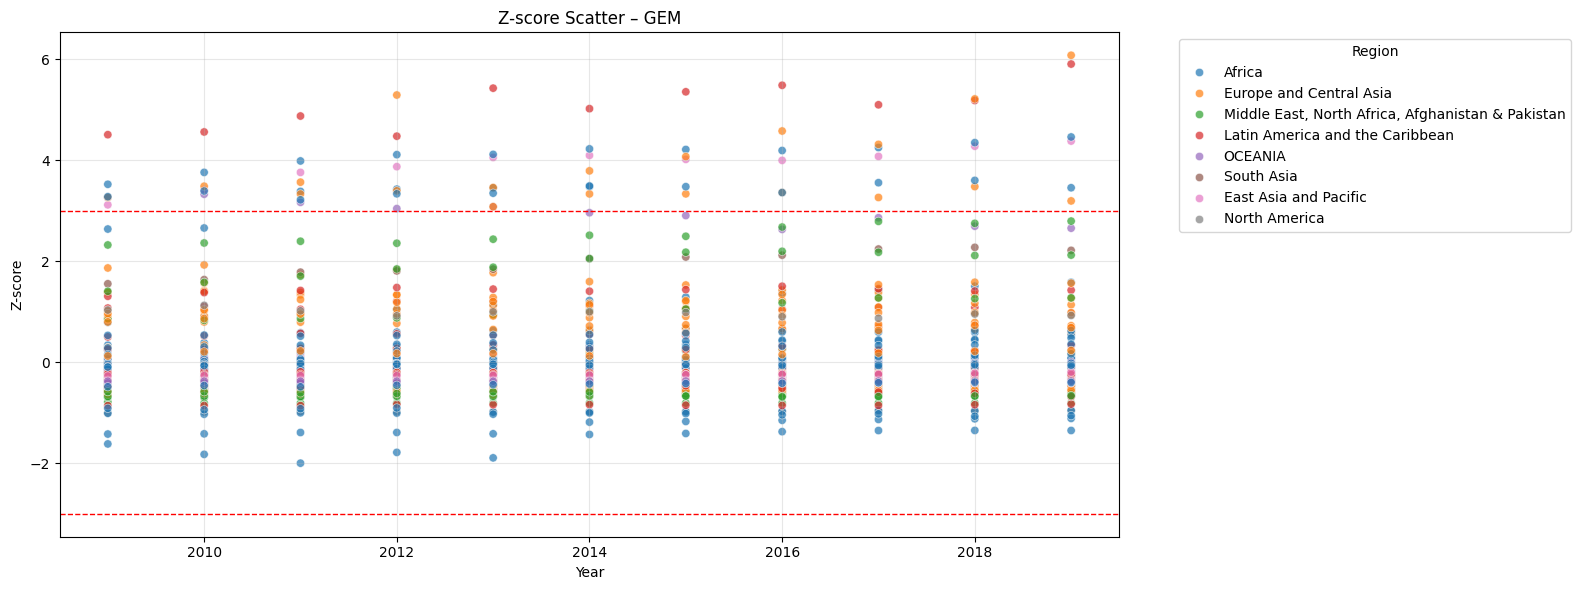

In [334]:
indicator = "GEM"

subset = df_outliers[df_outliers["indicator_id"] == indicator]

plt.figure(figsize=(16, 6))

sns.scatterplot(
    data=subset,
    x="year",
    y="z_score",
    hue="region",
    alpha=0.7
)

# Outlier thresholds
plt.axhline(3, color="red", linestyle="--", linewidth=1)
plt.axhline(-3, color="red", linestyle="--", linewidth=1)

plt.title(f"Z-score Scatter – {indicator}")
plt.ylabel("Z-score")
plt.xlabel("Year")
plt.legend(title="Region", bbox_to_anchor=(1.05, 1), loc="upper left")
plt.grid(alpha=0.3)

plt.tight_layout()
plt.show()


# Select a specific region and get the outliers for each indicator for intervals of 10 year